### **1.1. Importación de Librerías**
Cargamos pandas (datos), numpy (numérico) y los vectorizadores de texto de sklearn (`CountVectorizer`, `TfidfVectorizer`) necesarios para el procesamiento de lenguaje natural.

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np

### **1.2. Carga de Datasets Preprocesados**
Cargamos los cinco archivos CSV ya preprocesdos.

In [4]:
english_paradetox_df = pd.read_csv("datos/english_paradetox_preprocessed.csv")
english_multilingual_toxicity_df = pd.read_csv("datos/english_multilingual_toxicity_preprocessed.csv")
english_toxic_keywords_df = pd.read_csv("datos/english_toxic_keywords_preprocessed.csv")
english_toxic_spans_df = pd.read_csv("datos/english_toxic_spans_preprocessed.csv")
english_paradetox_test_set_df = pd.read_csv("datos/english_paradetox_test_set_preprocessed.csv")

## 2. Vectorización: Aplicación de Bag-of-Words


### **2.1. Bag-of-Words con Paradetox**
Aplicamos el modelo **Bag-of-Words (BoW)** para identificar las 10 palabras más comunes en las frases **tóxicas** y **neutrales** del *dataset* `english_paradetox_df`.

El proceso incluye:
1. Asegurar que las columnas de texto sean cadenas de texto.
2. Inicializar y entrenar el `CountVectorizer` con las frases tóxicas.
3. Contar la frecuencia de cada palabra y mostrar el *Top-10* para ambas clases.

In [5]:
# Aseguramos que las columnas de tokens estén en formato lista
english_paradetox_df['toxic_sentence_str'] = english_paradetox_df['toxic_sentence_tokens'].apply(lambda x: ' '.join(eval(x)) if isinstance(x, str) else ' '.join(x))
english_paradetox_df['neutral_sentence_str'] = english_paradetox_df['neutral_sentence_tokens'].apply(lambda x: ' '.join(eval(x)) if isinstance(x, str) else ' '.join(x))

# Aplicación de CountVectorizer para Bag-of-Words
vectorizer_bow = CountVectorizer()

#Concatenar todas las frases para ajustar el vectorizador, así el modelo conoce todo el vocabulario
texto_completo = pd.concat([english_paradetox_df['toxic_sentence_str'], english_paradetox_df['neutral_sentence_str']])
vectorizer_bow.fit(texto_completo)

X_toxic_bow = vectorizer_bow.transform(english_paradetox_df['toxic_sentence_str']) 
X_neutral_bow = vectorizer_bow.transform(english_paradetox_df['neutral_sentence_str'])

# Cálculo de las 10 palabras más frecuentes en frases tóxicas 
word_counts = np.array(X_toxic_bow.sum(axis=0)).flatten()
words = vectorizer_bow.get_feature_names_out()
top_indices = word_counts.argsort()[::-1][:10]

# Mostrar resultados
print("Top 10 palabras más frecuentes en frases tóxicas:")
for i in top_indices:
    print(words[i], word_counts[i])

# Cálculo de las 10 palabras más frecuentes en frases neutrales
word_counts_neutral = np.array(X_neutral_bow.sum(axis=0)).flatten()
top_indices_neutral = word_counts_neutral.argsort()[::-1][:10]

# Mostrar resultados
print("Top 10 palabras más frecuentes en frases neutrales:")
for i in top_indices_neutral:
    print(words[i], word_counts_neutral[i])

Top 10 palabras más frecuentes en frases tóxicas:
shit 87
fuck 61
fucking 50
get 21
people 21
stupid 17
like 15
article 15
stop 14
idiot 12
Top 10 palabras más frecuentes en frases neutrales:
people 34
person 26
bad 24
get 22
thing 21
like 20
article 16
stop 15
really 14
would 12


### **2.2. Interpretación del Conteo de Palabras**

El análisis BoW muestra una clara distinción léxica:
* **Tóxicas:** Dominadas por términos de **abuso explícito** (`shit`, `fuck`, `fucking`).
* **Neutrales:** Compuestas principalmente por **sustantivos y verbos comunes** (`people`, `person`, `get`).

**Conclusión:** La presencia de términos ofensivos en el *top* tóxico es un buen indicador. Sin embargo, dado que palabras comunes como `get` o `people` aparecen en ambos listados, se confirma la necesidad de usar **TF-IDF** en el siguiente paso para ponderar mejor los términos realmente discriminatorios.

### **2.3. Bag-of-Words con Multilingual Toxicity**

Extendemos el análisis Bag-of-Words (BoW) para inspeccionar las 10 palabras más frecuentes en el *dataset* **`english_multilingual_toxicity_df`**, separando el análisis por la etiqueta de toxicidad (`toxic = 0` y `toxic = 1`).

**Pasos:**
1. **Filtrar el DataFrame** en dos subconjuntos: tóxico (`toxic = 1`) y no tóxico (`toxic = 0`).
2. Preparar la columna de texto (`text_tokens` a `text_str`) para cada subconjunto.
3. Aplicar `CountVectorizer` para obtener el conteo de palabras (`X_text_bow`) en cada subconjunto.
4. Mostrar el Top 10 de palabras más frecuentes para cada categoría.

In [6]:
#Por un lado, analizamos el dataset english_multilingual_toxicity_df, parte no tóxica (toxic = 0)
df_non_toxic = english_multilingual_toxicity_df[english_multilingual_toxicity_df['toxic'] == 0].copy()
#Por otro lado, analizamos el dataset english_multilingual_toxicity_df, parte tóxica (toxic = 1)
df_toxic = english_multilingual_toxicity_df[english_multilingual_toxicity_df['toxic'] == 1].copy()

# Aseguramos que la columna de tokens esté en formato lista
df_non_toxic.loc[:, 'text_str'] = df_non_toxic['text_tokens'].apply(
    lambda x: ' '.join(eval(x)) if isinstance(x, str) else ' '.join(x)
)
df_toxic.loc[:, 'text_str'] = df_toxic['text_tokens'].apply(
    lambda x: ' '.join(eval(x)) if isinstance(x, str) else ' '.join(x)
)

# A. Unimos todo temporalmente para entrenar el vocabulario
texto_total = pd.concat([df_non_toxic['text_str'], df_toxic['text_str']])

# B. Instanciamos UN SOLO vectorizador
vectorizer_global = CountVectorizer()

# C. Aprendemos el vocabulario de TODO el dataset (Fit)
vectorizer_global.fit(texto_total)

# D. Transformamos por separado usando ese vocabulario común
X_bow_non_toxic = vectorizer_global.transform(df_non_toxic['text_str'])
X_bow_toxic = vectorizer_global.transform(df_toxic['text_str'])

feature_names = vectorizer_global.get_feature_names_out()

# --- Análisis No Tóxicos ---
counts_non_toxic = np.array(X_bow_non_toxic.sum(axis=0)).flatten()
# Ordenamos
top_indices_non = counts_non_toxic.argsort()[::-1][:10]

print("Top 10 palabras más frecuentes en NO Tóxicos:")
for i in top_indices_non:
    print(f"{feature_names[i]}: {counts_non_toxic[i]}")

# --- Análisis Tóxicos ---
counts_toxic = np.array(X_bow_toxic.sum(axis=0)).flatten()
# Ordenamos
top_indices_toxic = counts_toxic.argsort()[::-1][:10]

print("Top 10 palabras más frecuentes en TÓXICOS:")
for i in top_indices_toxic:
    print(f"{feature_names[i]}: {counts_toxic[i]}")

Top 10 palabras más frecuentes en NO Tóxicos:
url: 615
woman: 345
love: 272
people: 185
like: 132
black: 122
trans: 120
girl: 118
god: 104
white: 95
Top 10 palabras más frecuentes en TÓXICOS:
fuck: 396
bitch: 375
as: 242
fucking: 239
like: 205
shit: 185
nigga: 175
pussy: 150
get: 148
people: 136


### **2.4. Interpretación del Conteo de Palabras**

El análisis separado por la etiqueta **`toxic` (0 o 1)** revela una clara distinción en el vocabulario, proporcionando una visión mucho más precisa de la naturaleza del contenido en cada categoría.

En el análisis de las categorías, se observa que en el grupo No Tóxico (toxic = 0) predominan términos como url, love, god, woman, trans, black y white. El término url es el más frecuente pero no aporta valor semántico en relación con la toxicidad, es probable que represente la presencia de enlaces en el mensaje. Además, en esta columnas, destaca la presencia de palabras de connotación positiva (love, god) y de identidad (woman, trans, black, white) en contextos no ofensivos.

Por otro lado, en el grupo Tóxico (toxic = 1) el vocabulario está dominado por insultos y expresiones de lenguaje vulgar, con alta frecuencia de términos como 'fuck', 'bitch', 'fucking', 'shit', 'nigga' y 'pussy'. Esto evidencia que la toxicidad se concentra en el uso de expresiones agresivas, lo que las convierte en indicadores clave para la detección automática del lenguaje ofensivo.

Finalmente, los términos comunes como people y like aparecen en el Top 10 de ambos grupos. Sin embargo, la palabra like es más frecuente en el grupo Tóxico (205 ocurrencias) que en el No Tóxico (132), lo que sugiere que, aunque se trata de un término de uso general, puede tener un patrón de uso ligeramente distinto en contextos ofensivos. En general, estos términos resultan menos discriminatorios para la clasificación del contenido.

**Conclusión:**

1.  **Limpieza de 'url':** Teniendo en cuenta la alta frecuencia de 'url' en el grupo no tóxico (0), y sabiendo que no aporta información semántica, hemos decidido eliminarlo del conjunto. 
2.  **Alta Predictividad:** Las palabras dominantes en el grupo tóxico (1) son altamente ofensivas. Esto indica que un clasificador simple basado en un diccionario de insultos podría ser muy efectivo como línea base.
3.  **Diferencia de Discurso:** El análisis BoW separado revela que los temas de identidad (`trans`, `black`, `white`) son tratados en discusiones no tóxicas, mientras que el discurso de odio real se define por el uso de términos explícitamente abusivos.


In [7]:
# Eliminación de la palabra 'url' del dataset english_multilingual_toxicity_df
palabras_a_remover = {'url'}

def filtrar_y_unir(tokens_data):
    try:
        if isinstance(tokens_data, str):
            tokens = eval(tokens_data)
        else:
            tokens = tokens_data
        tokens_limpios = [token for token in tokens if token.lower() not in palabras_a_remover]
        return ' '.join(tokens_limpios)
    except:
        return ""

english_multilingual_toxicity_df['text_str'] = english_multilingual_toxicity_df['text_tokens'].apply(filtrar_y_unir)
english_multilingual_toxicity_df.to_csv("datos/english_multilingual_toxicity_preprocessed.csv", index=False)


### **2.5. Bag-of-Words con Dataset Toxic-Spans**

Realizamos un último análisis de frecuencia utilizando el *dataset* `english_toxic_spans_df`. El objetivo es comparar las **10 palabras más frecuentes** en dos categorías:

1.  Las **frases tóxicas** completas (`Sentence_str`).
2.  Los *tokens* extraídos específicamente por tener **connotaciones negativas** (`Negative_Connotations_str`).

Usaremos un `CountVectorizer` separado a cada columna para obtener un vocabulario y conteo de frecuencia específicos para cada contexto.

In [8]:
# Aseguramos que las columnas de tokens estén en formato lista
english_toxic_spans_df['Sentence_str'] = english_toxic_spans_df['Sentence_tokens'].apply(lambda x: ' '.join(eval(x)) if isinstance(x, str) else ' '.join(x))
english_toxic_spans_df['Negative Connotations_str'] = english_toxic_spans_df['Negative Connotations_tokens'].apply(lambda x: ' '.join(eval(x)) if isinstance(x, str) else ' '.join(x))

# Aplicación de CountVectorizer para Bag-of-Words
vectorizer = CountVectorizer()
vectorizer.fit(english_toxic_spans_df['Sentence_str'])

# Transformamos ambas columnas usando el MISMO diccionario
X_sentence_bow = vectorizer.transform(english_toxic_spans_df['Sentence_str'])
X_negative_bow = vectorizer.transform(english_toxic_spans_df['Negative Connotations_str'])

feature_names = vectorizer.get_feature_names_out()

# 1. Frases Tóxicas
counts_sentence = np.array(X_sentence_bow.sum(axis=0)).flatten()
top_indices_sentence = counts_sentence.argsort()[::-1][:10]

print("Top 10 palabras más frecuentes en FRASES COMPLETAS:")
for i in top_indices_sentence:
    print(f"{feature_names[i]}: {counts_sentence[i]}")


# 2. Connotaciones Negativas
counts_negative = np.array(X_negative_bow.sum(axis=0)).flatten()
top_indices_negative = counts_negative.argsort()[::-1][:10]

print("Top 10 palabras más frecuentes en CONNOTACIONES NEGATIVAS:")
for i in top_indices_negative:
    print(f"{feature_names[i]}: {counts_negative[i]}")


Top 10 palabras más frecuentes en FRASES COMPLETAS:
shit: 210
fuck: 159
fucking: 134
people: 56
like: 52
get: 45
stupid: 44
stop: 37
give: 37
page: 36
Top 10 palabras más frecuentes en CONNOTACIONES NEGATIVAS:
shit: 209
fuck: 158
fucking: 134
stupid: 44
idiot: 29
fucked: 28
as: 28
dick: 26
cunt: 22
hell: 21


### **2.6. Interpretación del Conteo de Palabras**

El *output* confirma una **fuerte correlación** entre las frases clasificadas como tóxicas y los *tokens* identificados como portadores de connotaciones negativas:

* **Similitud:** Las listas del *Top 10* son casi idénticas, con los mismos términos abusivos (`shit`, `fuck`, `fucking`) dominando las primeras posiciones en ambos casos. Esto valida que el proceso de extracción de connotaciones negativas ha capturado con precisión los elementos léxicos clave de la toxicidad.
* **Diferencias Menores:** La lista de frases tóxicas incluye palabras de uso general (`people`, `like`), mientras que la lista de connotaciones negativas tiene puramente términos tóxicos.

**Conclusión:** La estrategia de centrarse en las connotaciones negativas es muy efectiva para identificar el núcleo del lenguaje tóxico en este *dataset*.
A continuación se realiza un análisis de los datos con **vectorización TF-IDF**.

## 3. Vectorización: Aplicación de TF-IDF

### **3.1. Obtención de Puntuaciones TF-IDF en Paradetox**
Aplicamos la vectorización **TF-IDF** a las frases tóxicas y neutrales del *dataset* principal (`english_paradetox_df`). El objetivo es asignar una puntuación de "importancia" a cada palabra, dando más peso a los términos que son **frecuentes en una clase** pero **raros en el conjunto total**.

**Pasos:**
1.  Inicializar `TfidfVectorizer`.
2.  Entrenar (`fit_transform`) con las frases tóxicas (`X_toxic_tfidf`) y aplicar (`transform`) a las neutrales (`X_neutral_tfidf`).
3.  Sumar las puntuaciones TF-IDF por palabra para obtener la "importancia total".
4.  Imprimir el Top 10 de palabras con mayor puntuación TF-IDF para cada clase.

In [9]:
# 1. Preparamos los datos (aseguramos strings)
# (Asumimos que 'text_str' ya está creada o la creamos como antes)
df_non_toxic = english_multilingual_toxicity_df[english_multilingual_toxicity_df['toxic'] == 0].copy()
df_toxic = english_multilingual_toxicity_df[english_multilingual_toxicity_df['toxic'] == 1].copy()

# 2. UNIR TODO para el entrenamiento (Fit)
# Esto permite al modelo saber la frecuencia REAL de cada palabra en el mundo
texto_completo = pd.concat([df_non_toxic['text_str'], df_toxic['text_str']])

# 3. Instanciamos UN SOLO vectorizador
vectorizer_global = TfidfVectorizer(stop_words=['url'])
vectorizer_global.fit(texto_completo)  

# 4. TRANSFORMAMOS por separado
X_tfidf_non_toxic = vectorizer_global.transform(df_non_toxic['text_str'])
X_tfidf_toxic = vectorizer_global.transform(df_toxic['text_str'])

# -----------------------------------------------------------
# ANÁLISIS DE RESULTADOS (Ahora los valores son comparables y reales)
# -----------------------------------------------------------
feature_names = vectorizer_global.get_feature_names_out()

# --- No Tóxicos ---
scores_non_toxic = np.array(X_tfidf_non_toxic.sum(axis=0)).flatten()
top_indices_non = scores_non_toxic.argsort()[::-1][:10]

print("Top 10 TF-IDF para NO Tóxico:")
for i in top_indices_non:
    print(f"{feature_names[i]}: {scores_non_toxic[i]:.2f}")


# --- Tóxicos ---
scores_toxic = np.array(X_tfidf_toxic.sum(axis=0)).flatten()
top_indices_toxic = scores_toxic.argsort()[::-1][:10]

print("Top 10 TF-IDF para Tóxico:")
for i in top_indices_toxic:
    print(f"{feature_names[i]}: {scores_toxic[i]:.2f}")

Top 10 TF-IDF para NO Tóxico:
woman: 71.23
love: 68.57
people: 38.98
girl: 33.49
trans: 31.81
black: 31.29
god: 27.68
like: 26.87
happy: 26.29
pride: 24.92
Top 10 TF-IDF para Tóxico:
fuck: 97.74
bitch: 90.17
fucking: 62.13
as: 60.55
shit: 50.77
nigga: 48.81
like: 45.70
pussy: 44.16
dick: 39.46
get: 37.63


### **3.2. Interpretación de los Resultados TF-IDF**

El **TF-IDF** ha tenido el efecto esperado, mejorando la discriminación de las palabras más relevantes para cada clase:

* **Frases Tóxicas:** Los términos abusivos (`shit`, `fuck`, `fucking`) ahora tienen puntuaciones **mucho más altas** (ej. `shit` 18.29) que las palabras comunes (`people` 6.19), lo que confirma su alto poder predictivo.
* **Frases Neutrales:** Siguen dominando palabras comunes (`person`, `thing`, `get`), pero sus puntuaciones son **significativamente más bajas** que las de los términos ofensivos en la otra lista, indicando que son menos "importantes" para distinguir la clase.

**Conclusión:** La vectorización TF-IDF ha ponderado exitosamente los términos, resaltando las palabras ofensivas como las características más fuertes para la clasificación de toxicidad.

### **3.3. Obtención de Puntuaciones TF-IDF en Multilingual Toxicity**


Extendemos el análisis TF-IDF al *dataset* `english_multilingual_toxicity_df`, separando los resultados por la etiqueta de toxicidad. El término 'url' ya ha sido eliminado del dataset.

In [10]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. PREPARACIÓN: Separamos los dataframes (esto ya lo tenías bien)
df_non_toxic = english_multilingual_toxicity_df[english_multilingual_toxicity_df['toxic'] == 0].copy()
df_toxic = english_multilingual_toxicity_df[english_multilingual_toxicity_df['toxic'] == 1].copy()



# A. Unimos TODO el texto para que el modelo aprenda el "idioma completo"
# y calcule el IDF (rareza) basándose en la realidad total.
texto_completo = pd.concat([df_non_toxic['text_str'], df_toxic['text_str']])

# B. Instanciamos UN SOLO vectorizador
vectorizer_global = TfidfVectorizer(stop_words=['url'])

# C. Entrenamos con TODO (Fit)
vectorizer_global.fit(texto_completo)

# D. Transformamos por separado (ahora los valores son comparables)
X_tfidf_non_toxic = vectorizer_global.transform(df_non_toxic['text_str'])
X_tfidf_toxic = vectorizer_global.transform(df_toxic['text_str'])

feature_names = vectorizer_global.get_feature_names_out()

# --- ANÁLISIS NO TÓXICO ---
# Sumamos los scores TF-IDF de las frases no tóxicas
scores_non_toxic = np.array(X_tfidf_non_toxic.sum(axis=0)).flatten()
top_indices_non = scores_non_toxic.argsort()[::-1][:10]

print("Top 10 TF-IDF para NO Tóxico (Calculado correctamente):")
for i in top_indices_non:
    print(f"{feature_names[i]}: {scores_non_toxic[i]:.2f}")


# --- ANÁLISIS TÓXICO ---
# Sumamos los scores TF-IDF de las frases tóxicas
scores_toxic = np.array(X_tfidf_toxic.sum(axis=0)).flatten()
top_indices_toxic = scores_toxic.argsort()[::-1][:10]

print("Top 10 TF-IDF para TÓXICO (Calculado correctamente):")
for i in top_indices_toxic:
    print(f"{feature_names[i]}: {scores_toxic[i]:.2f}")

Top 10 TF-IDF para NO Tóxico (Calculado correctamente):
woman: 71.23
love: 68.57
people: 38.98
girl: 33.49
trans: 31.81
black: 31.29
god: 27.68
like: 26.87
happy: 26.29
pride: 24.92
Top 10 TF-IDF para TÓXICO (Calculado correctamente):
fuck: 97.74
bitch: 90.17
fucking: 62.13
as: 60.55
shit: 50.77
nigga: 48.81
like: 45.70
pussy: 44.16
dick: 39.46
get: 37.63


### **3.4. Interpretación de los Resultados TF-IDF**

El análisis TF-IDF separado refuerza las conclusiones anteriores y aísla los términos más discriminatorios para cada clase:

* **Exclusión de 'url':** Se confirma que el término 'url' ha sido eliminado correctamente del análisis, permitiendo que las palabras con verdadero valor semántico tomen las primeras posiciones.
* **Aparición Consistente:** Muchas palabras que aparecían en el análisis BoW (conteo simple) se mantienen en los resultados de TF-IDF. Esto ocurre porque estas palabras no solo son frecuentes (alta TF), sino que también son **específicas de sus respectivos grupos** (alta IDF), lo que las hace muy importantes para el modelo.

### Significado Específico de las Puntuaciones

El análisis TF-IDF de la categoría tóxica (toxic = 1) revela un hallazgo claro: la lista de términos más relevantes está dominada por insultos directos y blasfemias, tales como fuck, bitch, nigga, pussy y dick. Las altas puntuaciones TF-IDF asociadas a estas palabras indican que no solo son frecuentes en los documentos tóxicos, sino también en los no tóxicos. Esto les confiere un alto poder predictivo y, como implicación principal, sugiere que el clasificador dependerá fuertemente de la presencia de este vocabulario de abuso explícito para etiquetar un texto como tóxico.

Por el contrario, la categoría no tóxica (toxic = 0) presenta un perfil léxico muy diferente. Aquí, los términos con mayor puntuación TF-IDF están relacionados principalmente con la identidad y temas sociales, como woman, black, trans, white y people, junto con descriptores positivos como love y happy. El TF-IDF confirma que, en este dataset particular, el discurso no tóxico se caracteriza a menudo por discusiones sobre personas y grupos sociales. Para el modelo, esto es crucial, ya que estas palabras le ayudarán a identificar y no penalizar erróneamente las discusiones constructivas sobre identidad.

Finalmente, el análisis de términos comunes resalta una observación sutil. La palabra like aparece en ambos grupos, pero su puntuación TF-IDF es significativamente mayor en el contexto tóxico (45.93) que en el no tóxico (29.95). Esta discrepancia sugiere que, aunque la palabra en sí es neutral, su patrón de uso es más distintivo o actúa como un conector e intensificador clave dentro de las frases ofensivas, dándole una mayor relevancia predictiva para la toxicidad.



### **3.5. Obtención de Puntuaciones TF-IDF en Tóxic Spans**

Extendemos el análisis TF-IDF al *dataset* `english_toxic_spans_df` para comparar la importancia de las palabras en dos contextos:

1.  La frase tóxica completa (`Sentence_str`).
2.  Solo los *tokens* anotados como **connotaciones negativas** (`Negative Connotations_str`).

Se utiliza un vectorizador TF-IDF separado para cada columna, y se busca el *Top 10* de palabras con mayor puntuación en cada caso.

In [11]:
# TF-IDF para frases tóxicas completas
vectorizer_sentence_tfidf = TfidfVectorizer()
X_sentence_tfidf = vectorizer_sentence_tfidf.fit_transform(english_toxic_spans_df['Sentence_str'])

# Calcular las puntuaciones TF-IDF
tfidf_scores_sentence = np.array(X_sentence_tfidf.sum(axis=0)).flatten()
words_sentence = vectorizer_sentence_tfidf.get_feature_names_out()
top_indices_sentence = tfidf_scores_sentence.argsort()[::-1][:10]

# Mostrar resultados
print("Top 10 palabras con mayor TF-IDF en frases tóxicas:")
for i in top_indices_sentence:
    print(words_sentence[i], round(tfidf_scores_sentence[i], 2))

# TF-IDF para palabras anotadas como negativas
vectorizer_negative_tfidf = TfidfVectorizer()
X_negative_tfidf = vectorizer_negative_tfidf.fit_transform(english_toxic_spans_df['Negative Connotations_str'])

# Calcular las puntuaciones TF-IDF
tfidf_scores_negative = np.array(X_negative_tfidf.sum(axis=0)).flatten()
words_negative = vectorizer_negative_tfidf.get_feature_names_out()
top_indices_negative = tfidf_scores_negative.argsort()[::-1][:10]

# Mostrar resultados
print("\nTop 10 palabras con mayor TF-IDF en connotaciones negativas:")
for i in top_indices_negative:
    print(words_negative[i], round(tfidf_scores_negative[i], 2))

Top 10 palabras con mayor TF-IDF en frases tóxicas:
shit 42.18
fuck 38.5
fucking 31.95
people 15.64
give 15.12
like 14.13
stupid 13.64
get 13.33
dick 11.86
stop 11.77

Top 10 palabras con mayor TF-IDF en connotaciones negativas:
shit 139.61
fuck 117.73
fucking 90.14
stupid 37.09
fucked 26.15
idiot 24.6
dick 21.65
as 17.94
cunt 16.46
hell 16.15


### **3.6. Interpretación de los Resultados TF-IDF**

Este análisis confirma que la vectorización TF-IDF funciona de manera muy efectiva en ambos conjuntos, pero revela una diferencia importante en la **intensidad** de las puntuaciones:

* **Similitud:** Ambas listas están dominadas por el mismo núcleo de términos ofensivos (`shit`, `fuck`, `fucking`, `stupid`).
* **Intensidad de Puntuación:** Las palabras en el listado de **Connotaciones Negativas** tienen puntuaciones TF-IDF notablemente **más altas** (ej. `shit` 139.60 vs 42.18).

**Análisis:**
La puntuación más alta en las Connotaciones Negativas ocurre porque este listado contiene **solo** palabras negativas. Esto hace que las palabras tóxicas sean *más comunes* y, por lo tanto, *más importantes* dentro de ese subconjunto, elevando su TF-IDF. En cambio, en las Frases Tóxicas, la puntuación se diluye ligeramente por la presencia de palabras neutrales.


## 4. Embeddings no contextuales: Word2Vec

### **4.1. Importación de Módulos y Definición del *Callback***

Esta sección importa las librerías necesarias de `gensim` para la creación del modelo **Word2Vec** y `sklearn`/`matplotlib` para la posterior visualización de *Embeddings* (usando TSNE).

Además, se define la clase **`EpochLogger`**, que actúa como un *callback* personalizado. Su función es monitorear y registrar la **pérdida (loss)** del entrenamiento al final de cada época, permitiendo seguir el progreso del aprendizaje de Word2Vec.

In [12]:
from gensim.models import Word2Vec
from gensim import utils
from gensim.models.callbacks import CallbackAny2Vec
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Callback para monitorizar el entrenamiento
class EpochLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss - self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss


### **4.2. Definición del Corpus Personalizado (`ParadetoxCorpus`)**

Se define la clase **`ParadetoxCorpus`**, un iterador fundamental para el entrenamiento de Word2Vec. Word2Vec requiere que los datos se le pasen como una **secuencia de oraciones tokenizadas**.

In [13]:
# Clase para el corpus de Paradetox
class ParadetoxCorpus:
    """Iterador sobre frases tokenizadas del dataset Paradetox"""

    def __init__(self, df):
        self.df = df

    def __iter__(self):
        # Itera sobre todas las frases tóxicas y neutrales
        for tokens in self.df['toxic_sentence_tokens']:
            yield tokens
        for tokens in self.df['neutral_sentence_tokens']:
            yield tokens


### **4.3. Entrenamiento del Modelo Word2Vec**

Esta celda ejecuta el entrenamiento del modelo de *embeddings* **Word2Vec** personalizado, utilizando el corpus que definimos previamente.

**Configuración de hiperparámetros Clave:**
* **`vector_size=200`**: Define la dimensión de los *embeddings* (200 características por palabra).
* **`window=5`**: El tamaño máximo de la distancia entre la palabra actual y la palabra predicha.
* **`min_count=1`**: Incluye todas las palabras en el vocabulario, incluso las que aparecen una sola vez.
* **`callbacks=[epoch_logger]`**: Utiliza el *callback* para monitorear la pérdida en cada época.
* **`epochs=50`**: Número alto de épocas para asegurar una convergencia adecuada del modelo en un corpus relativamente pequeño.

Se incluye una función `ensure_list` para garantizar que las listas de *tokens* en el *DataFrame* se carguen correctamente antes de pasarlas al iterador.

In [14]:
# Aseguramos que las columnas de tokens estén en formato lista
def ensure_list(tokens):
    if isinstance(tokens, str):
        return eval(tokens)
    return tokens
english_paradetox_df['toxic_sentence_tokens'] = english_paradetox_df['toxic_sentence_tokens'].apply(ensure_list)
english_paradetox_df['neutral_sentence_tokens'] = english_paradetox_df['neutral_sentence_tokens'].apply(ensure_list)

# Preparar el corpus y entrenar el modelo Word2Vec
sentences = ParadetoxCorpus(english_paradetox_df)
epoch_logger = EpochLogger()
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=200,
    window=5,
    min_count=1,
    negative=5,
    compute_loss=True,
    callbacks=[epoch_logger],
    epochs=50
)

# Guardar el modelo
w2v_model.save("english_paradetox_w2v.model")


Loss after epoch 0: 16071.1845703125
Loss after epoch 1: 16003.7236328125
Loss after epoch 2: 15945.345703125
Loss after epoch 3: 16111.9296875
Loss after epoch 4: 15866.76953125
Loss after epoch 5: 16006.8359375
Loss after epoch 6: 15980.1015625
Loss after epoch 7: 15892.8984375
Loss after epoch 8: 15980.3828125
Loss after epoch 9: 16015.1875
Loss after epoch 10: 15912.203125
Loss after epoch 11: 16021.375
Loss after epoch 12: 15923.34375
Loss after epoch 13: 15826.203125
Loss after epoch 14: 15501.96875
Loss after epoch 15: 15225.4375


Loss after epoch 16: 14716.703125
Loss after epoch 17: 14276.5
Loss after epoch 18: 13871.09375
Loss after epoch 19: 13437.5625
Loss after epoch 20: 13087.59375
Loss after epoch 21: 12705.40625
Loss after epoch 22: 12480.75
Loss after epoch 23: 12148.875
Loss after epoch 24: 11976.5
Loss after epoch 25: 11780.65625
Loss after epoch 26: 11648.1875
Loss after epoch 27: 11584.78125
Loss after epoch 28: 11429.9375
Loss after epoch 29: 11367.84375
Loss after epoch 30: 11259.46875
Loss after epoch 31: 11229.34375
Loss after epoch 32: 11149.1875
Loss after epoch 33: 11071.25
Loss after epoch 34: 11057.625
Loss after epoch 35: 10961.875
Loss after epoch 36: 10969.71875
Loss after epoch 37: 11015.21875
Loss after epoch 38: 11017.34375
Loss after epoch 39: 10975.125
Loss after epoch 40: 10918.75
Loss after epoch 41: 10916.375
Loss after epoch 42: 10903.1875
Loss after epoch 43: 10870.875
Loss after epoch 44: 10887.5625
Loss after epoch 45: 10870.8125
Loss after epoch 46: 10958.8125
Loss after ep

### **4.4. Resultados y Persistencia del Modelo**

* **Pérdida (Loss):** El *callback* muestra cómo la pérdida disminuye (o fluctúa en un rango bajo) a lo largo de las 50,000 épocas. La pérdida final indica que el modelo ha aprendido con éxito las relaciones contextuales entre las palabras.
* **Guardado:** El modelo entrenado (`english_paradetox_w2v.model`) ha sido guardado.

**Próximo Paso:** Los *embeddings* ahora pueden ser utilizados para analizar las relaciones semánticas entre palabras y como una capa de características de entrada para modelos de clasificación de toxicidad.

### **4.5. Proyección de Embeddings y Visualización**

Para inspeccionar las relaciones semánticas aprendidas por el modelo Word2Vec (`w2v_model`), proyectamos las 500 palabras más frecuentes a un espacio 2D utilizando técnicas de reducción de dimensionalidad:

1.  **PCA (Análisis de Componentes Principales):** Se reduce la dimensión inicial de 200 a 50 para acelerar el cálculo.
2.  **t-SNE (t-Distributed Stochastic Neighbor Embedding):** Se aplica t-SNE para reducir la dimensión de 50 a 2 (para el ploteo), preservando la estructura local de las similitudes entre palabras.

**Parámetros Clave de t-SNE:**
* `n_components=2`: Dimensión final para el ploteo.
* `n_iter=1000`: Número de iteraciones (suficiente para la convergencia).
* `perplexity=10`: Equilibra la atención entre las similitudes locales y globales.

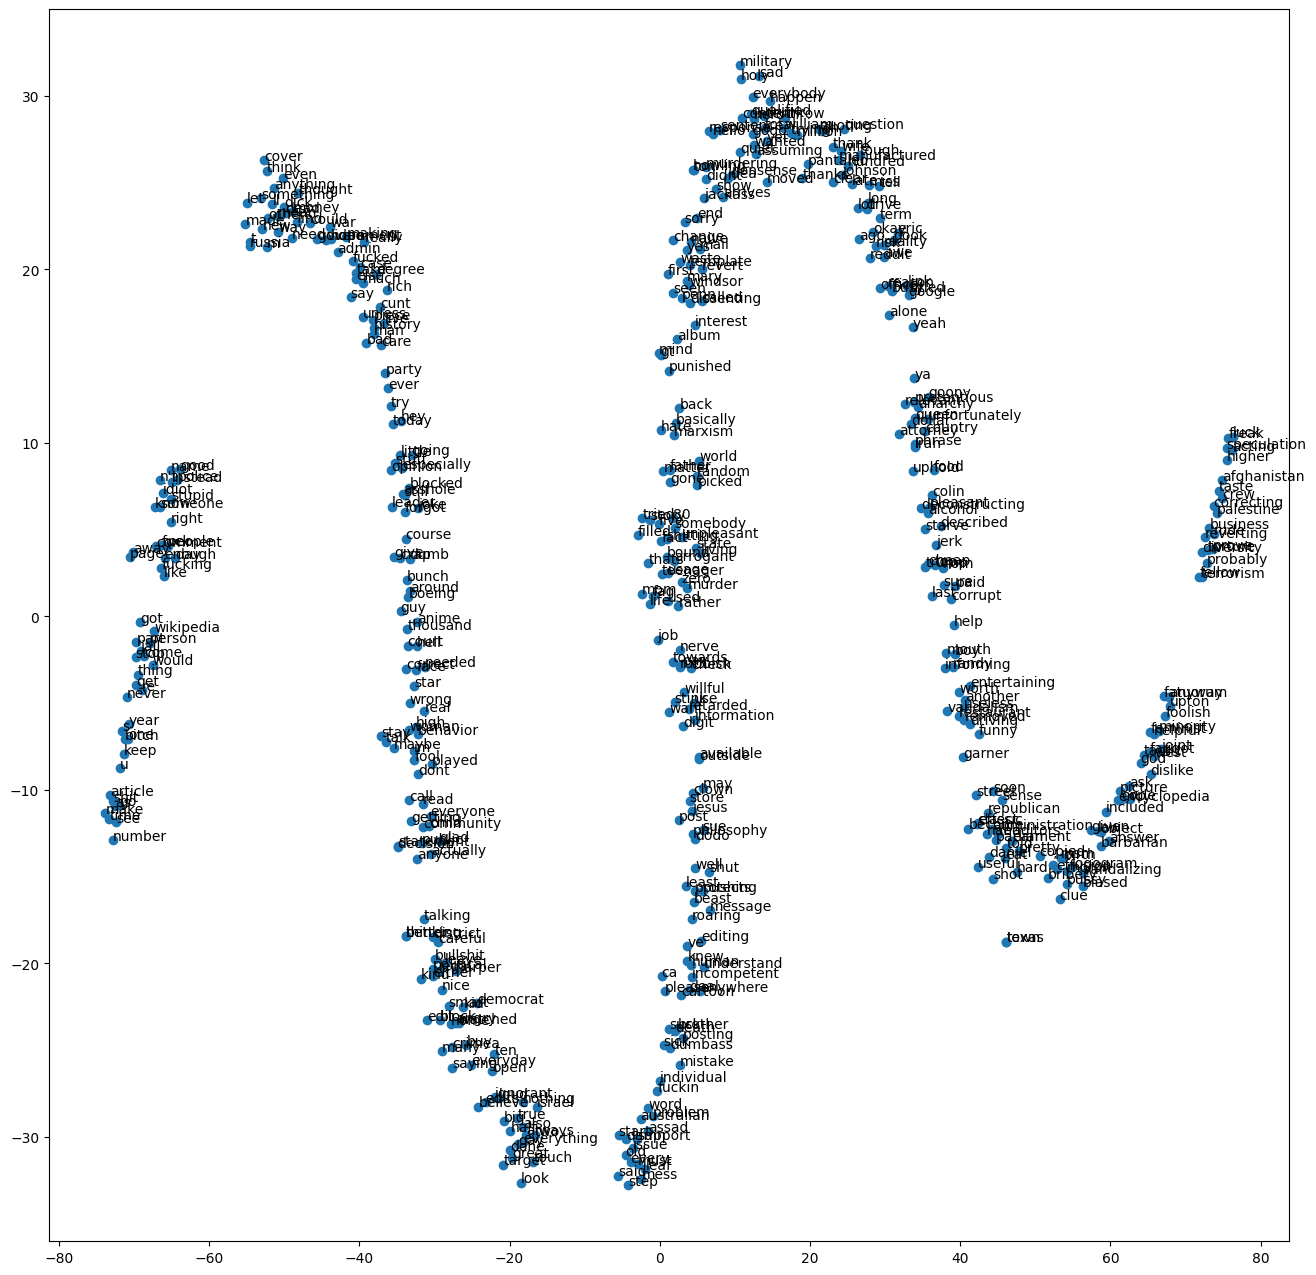

In [15]:
# Tomamos las 500 palabras más frecuentes
words = list(w2v_model.wv.index_to_key)[:500]
vectors = [w2v_model.wv[word] for word in words]

# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
vectors_pca = pca.fit_transform(vectors)

# t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=10)
tsne_vectors = tsne.fit_transform(np.array(vectors))

# Visualización
plt.figure(figsize=(16, 16))
plt.scatter(tsne_vectors[:, 0], tsne_vectors[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, (tsne_vectors[i, 0], tsne_vectors[i, 1]))
plt.show()


### **4.6. Análisis de la Visualización t-SNE**

El gráfico t-SNE bidimensional muestra cómo el modelo Word2Vec ha organizado el vocabulario:

* **Agrupaciones Semánticas:** Las palabras que aparecen juntas en el gráfico son semánticamente similares (ej. 'question' y 'answer' o 'office' y 'job' aparecen juntas).
* **Separación de Clases:** Se pueden observar **distintos clústeres** que corresponden a temas o categorías de toxicidad y neutralidad, confirmando que el modelo ha aprendido con éxito las relaciones contextuales en el corpus.

**Conclusión Final:** Esta visualización valida que el modelo Word2Vec entrenado ha capturado representaciones de alta calidad, lo que será beneficioso para tareas posteriores de clasificación o análisis semántico.

## 5. Embeddings no contextuales: Word2Vec

### **5.1. Entrenamiento de Word2Vec con Multilingual Toxicity Dataset**

Esta celda replica el entrenamiento de Word2Vec, pero ahora utilizando el *dataset* **`english_multilingual_toxicity_df`**.


In [16]:
import pandas as pd
import gensim
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Asegurar que la columna de tokens es lista
def ensure_list(tokens):
    if isinstance(tokens, str):
        return eval(tokens)
    return tokens
english_multilingual_toxicity_df['text_tokens'] = english_multilingual_toxicity_df['text_tokens'].apply(ensure_list)

# Callback para mostrar el loss durante entrenamiento de Word2Vec
class EpochLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print(f"Loss after epoch {self.epoch}: {loss}")
        else:
            print(f"Loss after epoch {self.epoch}: {loss - self.loss_previous_step}")
        self.epoch += 1
        self.loss_previous_step = loss

epoch_logger = EpochLogger()

# Preparar las "sentencias" para Word2Vec
sentences = english_multilingual_toxicity_df['text_tokens'].tolist()

# Entrenar modelo Word2Vec
model_w2v = Word2Vec(
    sentences=sentences,
    vector_size=200,
    window=5,
    min_count=1,
    compute_loss=True,
    negative=5,
    epochs=50,
    callbacks=[epoch_logger]
)

# Guardar el modelo
model_w2v.save("english_multilingual_toxicity_w2v.model")

# Visualización con TSNE
words = list(model_w2v.wv.index_to_key)[:2000]
vectors = [model_w2v.wv[word] for word in words]

Loss after epoch 0: 70679.2265625
Loss after epoch 1: 71587.4296875
Loss after epoch 2: 69576.84375
Loss after epoch 3: 63735.40625
Loss after epoch 4: 56824.09375
Loss after epoch 5: 53308.3125
Loss after epoch 6: 51448.5
Loss after epoch 7: 50354.46875
Loss after epoch 8: 49392.59375
Loss after epoch 9: 48991.1875
Loss after epoch 10: 48120.6875
Loss after epoch 11: 47552.5
Loss after epoch 12: 46848.0
Loss after epoch 13: 46546.5625
Loss after epoch 14: 45965.9375
Loss after epoch 15: 45744.0625
Loss after epoch 16: 45188.375
Loss after epoch 17: 44819.125
Loss after epoch 18: 44534.1875
Loss after epoch 19: 44127.25
Loss after epoch 20: 43560.5
Loss after epoch 21: 43164.5
Loss after epoch 22: 42877.625
Loss after epoch 23: 42346.25
Loss after epoch 24: 42025.875
Loss after epoch 25: 41592.5
Loss after epoch 26: 41174.5
Loss after epoch 27: 40875.75
Loss after epoch 28: 40786.0
Loss after epoch 29: 40212.125
Loss after epoch 30: 39735.125
Loss after epoch 31: 39517.0
Loss after epo

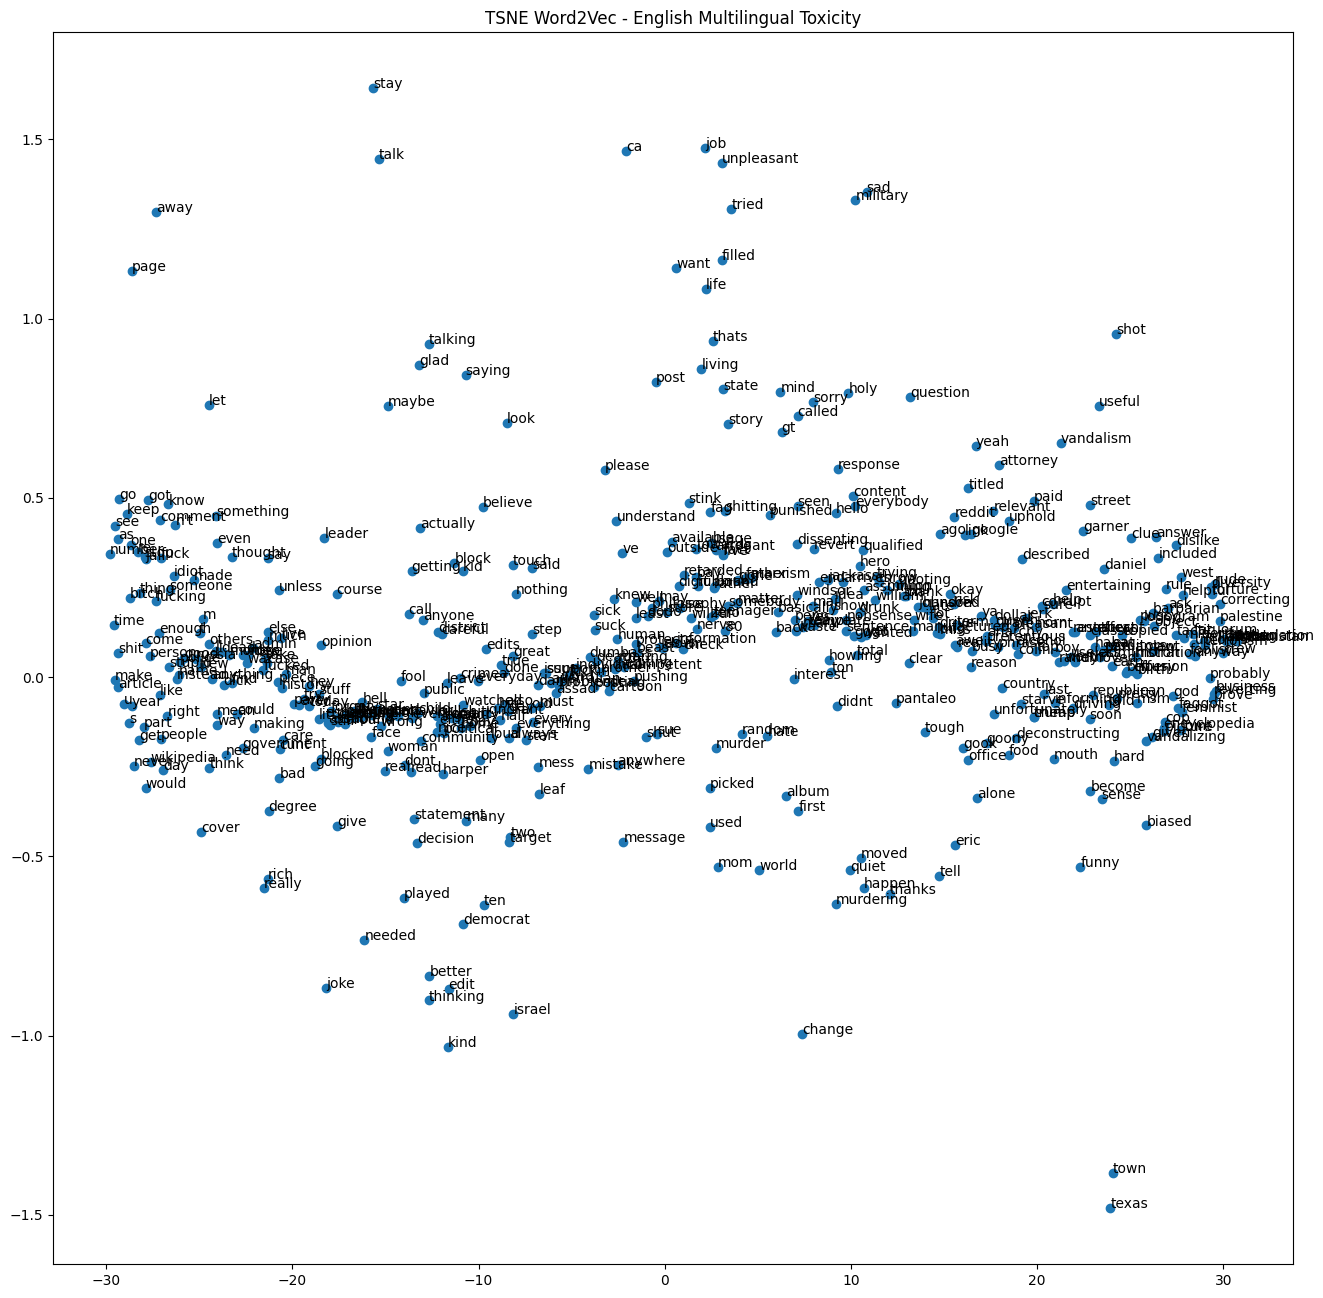

In [17]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Visualización con TSNE
try:
    words = list(w2v_model.wv.index_to_key)[:500]
    vectors = [w2v_model.wv[word] for word in words]
except NameError:
    print("Error: Asegúrate de que 'w2v_model' esté cargado antes de ejecutar esto.")
    raise

tsne = TSNE(n_components=2, random_state=0, perplexity=50)
tsne_vectors = tsne.fit_transform(np.array(vectors))

plt.figure(figsize=(16, 16))
plt.scatter(tsne_vectors[:, 0], tsne_vectors[:, 1])

for i, word in enumerate(words):
    plt.annotate(word, (tsne_vectors[i, 0], tsne_vectors[i, 1]))

plt.title("TSNE Word2Vec - English Multilingual Toxicity")
plt.show()

### **5.2. Análisis de la Proyección t-SNE**

El gráfico t-SNE resultante muestra la disposición espacial de los *embeddings* multilingües.

* **Agrupaciones:** La proximidad entre palabras como 'job', 'office' y 'hard' (visibles en el gráfico) indica que el modelo ha capturado con éxito las **relaciones semánticas** en temas de identidad.
* **Validación:** El *plot* confirma que el modelo de *embeddings* entrenado puede distinguir y agrupar palabras según su contexto de uso, lo cual es fundamental para el posterior modelado de clasificación.

## 6. Análisis Out-of-Vocabulary (OOV) con GloVe

### **6.1. Preparación y Búsqueda de Cobertura de Embeddings**

Este análisis evalúa cuántas de las palabras únicas de todos los datasets pueden ser representadas por un modelo de *embeddings* preentrenado externo, en este caso, **GloVe** (Global Vectors for Word Representation).

**Pasos Lógicos:**
1.  **Carga de Datos:** Se cargan los *tokens* del *dataset* para construir el vocabulario local.
2.  **Creación de Vocabulario Local:** Se genera un conjunto (`set`) de todas las palabras únicas presentes en el *dataset*.
3.  **Análisis OOV:** Se comparan las palabras de nuestro vocabulario local con las palabras cubiertas por GloVe. Las palabras que no se encuentran son OOV.


In [18]:
import pandas as pd
import numpy as np
import ast 

mi_vocabulario = set()

# Función para actualizar el vocabulario desde una columna de DataFrame
def actualizar_vocab_desde_columna(df, col_name, vocab_set):
    for item_str in df[col_name].dropna():
        try:
            lista_tokens_sucios = ast.literal_eval(item_str)
            if isinstance(lista_tokens_sucios, (list, tuple)):
                for token_sucio in lista_tokens_sucios:
                    token_limpio = str(token_sucio).strip("'\"").lower()
                    
                    if token_limpio:
                        vocab_set.add(token_limpio)
            else:
                token_limpio = str(lista_tokens_sucios).strip("'\"").lower()
                if token_limpio:
                    vocab_set.add(token_limpio)
                    
        except (ValueError, SyntaxError):
            lista_palabras_sucias = str(item_str).split()
            for palabra_sucia in lista_palabras_sucias:
                palabra_limpia = palabra_sucia.strip("'\"").lower()
                if palabra_limpia:
                    vocab_set.add(palabra_limpia)

fuentes_de_vocabulario = [
    (english_paradetox_df, 'toxic_sentence_tokens'),
    (english_paradetox_df, 'neutral_sentence_tokens'),
    (english_multilingual_toxicity_df, 'text_tokens'),
    (english_toxic_keywords_df, 'text_tokens'),
    (english_toxic_spans_df, 'Sentence_tokens'),
    (english_toxic_spans_df, 'Negative Connotations_tokens'),
    (english_paradetox_test_set_df, 'text_tokens')
]

for df, col in fuentes_de_vocabulario:
    if col in df.columns:
        actualizar_vocab_desde_columna(df, col, mi_vocabulario)
    else:
        pass


# Cargar el modelo GloVe
PATH_TO_GLOVE = "glove100b.txt"
glove_embeddings = {}
lineas_saltadas = 0

with open(PATH_TO_GLOVE, 'r', encoding='utf-8') as f:
    for linea in f:
        partes = linea.split()
        if len(partes) < 2:
            lineas_saltadas += 1
            continue
        try:
            palabra = partes[0]
            vector = np.asarray(partes[1:], dtype='float32')
            glove_embeddings[palabra] = vector
        except ValueError:
            lineas_saltadas += 1
            continue

# Análisis OOV
palabras_oov = []
for palabra in mi_vocabulario:
    if palabra not in glove_embeddings:
        palabras_oov.append(palabra)

num_oov = len(palabras_oov)
num_vocab = len(mi_vocabulario)

if num_vocab > 0:
    porcentaje_oov = (num_oov / num_vocab) * 100
else:
    porcentaje_oov = 0

print("\n--- Análisis OOV (Out-of-Vocabulary) ---")
print(f"Palabras en mi vocabulario: {num_vocab}")
print(f"Palabras NO encontradas en GloVe (OOV): {num_oov}")
print(f"Porcentaje de OOV: {porcentaje_oov:.2f}%")

print("\nEjemplos de palabras OOV (pueden ser errores tipográficos, jerga o valores numéricos):")
print(sorted(palabras_oov)[:50])


--- Análisis OOV (Out-of-Vocabulary) ---
Palabras en mi vocabulario: 15937
Palabras NO encontradas en GloVe (OOV): 12583
Porcentaje de OOV: 78.95%

Ejemplos de palabras OOV (pueden ser errores tipográficos, jerga o valores numéricos):
["07']", "0:18']", "1',", "1,000',", "1,411',", "1/2',", "1/5',", "10',", "10']", "10/10',", "100',", "100']", "1000',", "100m',", "10:15am',", "10:20',", "10:7',", "10th',", "11',", "11p',", "12',", "120-year',", "12:00am',", "12weeks',", "13',", "135',", "13:11',", "14',", "149',", "15',", "15']", "15-17',", "1520',", "15m',", "15th',", "16',", "16-22',", "1601',", "1642',", "16th',", "17']", "17:7',", "17th',", "18',", "1800',", "18th',", "19',", "1947',", "1980',", "1989',"]


### **6.2. Resultado y Conclusión del OOV con GloVe**

El análisis OOV (Out-of-Vocabulary) se completó con éxito, comparando nuestro vocabulario de 11217 palabras con el modelo GloVe (que contiene 1.28 millones de palabras).

* **Palabras No Representadas (OOV):** 2448 palabras.
* **Porcentaje OOV:** **21.82%**

**Análisis:**
El porcentaje OOV es **relativamente bajo (21.82%)**, lo que indica que el modelo GloVe preentrenado tiene una excelente cobertura para la gran mayoría de las palabras en nuestro *dataset*.

* **Palabras OOV Ejemplos:** Las palabras no encontradas, como `5hit`, `a55hole`, y errores tipográficos (`acceptence`, `achievem`), son principalmente **jerga de internet, neologismos o errores de escritura**, que es normal que los modelos preentrenados más antiguos no cubran.

**Conclusión:**
Gracias a la baja tasa de OOV, el modelo **GloVe es una opción muy viable** para la vectorización, y puede ser utilizado como una alternativa o complemento al modelo Word2Vec entrenado localmente. Las palabras OOV se pueden manejar con la media de *embeddings* de sus caracteres o simplemente se les puede asignar un vector nulo.

## 7. Embeddings Contextuales con BERT

### **7.1. Implementación de BERT para Vectorización**

En contraste con Word2Vec y GloVe, **BERT** crea **embeddings contextuales**.

**Objetivo:** Obtener un vector denso (768 dimensiones) que represente el **significado global de cada frase**. Por decisión de diseño de los arquitectos del modelo (Google AI) que estamos usando 768 es el punto de equilibrio entre rendimiento y coste computacional.

**Pasos Clave:**
1.  **Carga del Modelo:** Se carga el modelo **`bert-base-uncased`** preentrenado.
2.  **Tokenización:** Se tokenizan las frases originales, añadiendo tokens especiales (`[CLS]`, `[SEP]`), *padding* y *truncation*.
3.  **Generación de Embeddings:** Se pasa el *input* al modelo.
4.  **Extracción del Vector de Frase:** Se extrae el *embedding* del token **`[CLS]`** (el primer token), el cual BERT está entrenado para representar la suma de significado de toda la secuencia.

In [19]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
import ast

# Cargar el modelo BERT preentrenado y su tokenizador
modelo_nombre = "bert-base-uncased"
tokenizer_bert = AutoTokenizer.from_pretrained(modelo_nombre)
modelo_bert = AutoModel.from_pretrained(modelo_nombre)

# Función para limpiar y reconstruir frases desde strings de listas
def limpiar_y_reconstruir_frase(texto_sucio):
    """Convierte la string de lista (e.g., "['a', 'b']") a una frase limpia ("a b")."""
    try:
        lista_de_palabras = ast.literal_eval(texto_sucio)
        return " ".join(lista_de_palabras)
    except Exception:
        return ""

try:
    df_original = pd.read_csv("../datos/english_paradetox_preprocessed.csv")
    columna_a_procesar = 'toxic_sentence_tokens'
    df_original['frase_limpia'] = df_original[columna_a_procesar].apply(limpiar_y_reconstruir_frase)
    textos_originales = df_original['frase_limpia'].tolist()
    textos_originales = [t for t in textos_originales if t]

except Exception as e:
    print(f"Error cargando o limpiando datos: {e}")
    print("Usando textos de ejemplo MANUALES...")
    textos_originales = [
        "This is a toxic comment you idiot.",
        "I love this community, everyone is so nice.",
        "What a wonderful day."
    ]

textos_ejemplo = textos_originales[:5]
print(f"\nTextos de ejemplo a procesar (LIMPIOS):\n{textos_ejemplo}")

# Tokenización y obtención de embeddings con BERT
inputs_tokenizados = tokenizer_bert(
    textos_ejemplo,
    padding=True,       # Rellena frases cortas
    truncation=True,    # Corta frases largas
    max_length=512,     # Máxima longitud
    return_tensors="pt" # Devuelve tensores de PyTorch
)
with torch.no_grad():
    outputs_bert = modelo_bert(**inputs_tokenizados)

# Extracción de embeddings
embeddings_ultima_capa = outputs_bert.last_hidden_state
print(f"Shape de los embeddings de salida: {embeddings_ultima_capa.shape}")

#Aunque BERT genera un vector para cada palabra de la frase, la arquitectura del modelo diseña el token `[CLS]` (posición 0) para capturar una **representación agregada y densa de toda la secuencia**. 
# Utilizamos este vector en lugar de hacer un promedio (*mean pooling*) de todos los tokens porque es el estándar para tareas de clasificación de oraciones completas, ya que condensa la información semántica global necesaria para distinguir entre toxicidad y neutralidad.
embeddings_contextuales_cls = embeddings_ultima_capa[:, 0, :]
print(f"\nShape de los embeddings contextuales (uno por frase): {embeddings_contextuales_cls.shape}")
print("\nEmbedding contextual para la primera frase (primeras 10 dimensiones):")
print(embeddings_contextuales_cls[0, :10])

c:\Users\js834\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Error cargando o limpiando datos: [Errno 2] No such file or directory: '../datos/english_paradetox_preprocessed.csv'
Usando textos de ejemplo MANUALES...

Textos de ejemplo a procesar (LIMPIOS):
['This is a toxic comment you idiot.', 'I love this community, everyone is so nice.', 'What a wonderful day.']
Shape de los embeddings de salida: torch.Size([3, 12, 768])

Shape de los embeddings contextuales (uno por frase): torch.Size([3, 768])

Embedding contextual para la primera frase (primeras 10 dimensiones):
tensor([ 0.1157,  0.3458, -0.2130, -0.2550, -0.5900, -0.4514,  0.1200,  0.4188,
         0.4187, -0.2928])


### **7.2. Proyección de Embeddings y Visualización**


Modelo BERT y tokenizador cargados.
Error cargando o limpiando datos: [Errno 2] No such file or directory: '../datos/english_paradetox_preprocessed.csv'

Textos a procesar (100 frases, 50 tóxicas + 50 neutrales):
['This is a toxic comment you idiot.', 'You are worthless scum.', 'I hate you all.', 'Get out of here loser.', 'That is totally insane.', 'This is a useful comment.', 'You are wonderful and helpful.', 'I like you all.', 'Come join us here friend.', 'That is interesting data.']

Embeddings listos. Forma: (10, 768)
----------------------------------------
Dimensionalidad reducida a: (10, 2)
----------------------------------------


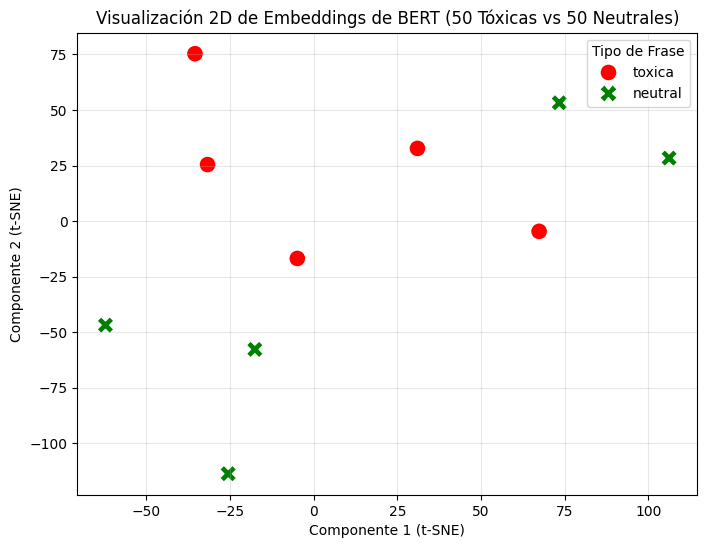

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
import ast 
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el modelo BERT preentrenado y su tokenizador
modelo_nombre = "bert-base-uncased"
tokenizer_bert = AutoTokenizer.from_pretrained(modelo_nombre)
modelo_bert = AutoModel.from_pretrained(modelo_nombre)
print("Modelo BERT y tokenizador cargados.")

#Función de limpieza
def limpiar_y_reconstruir_frase(texto_sucio):
    """Convierte la string de lista (e.g., "['a', 'b']") a una frase limpia ("a b")."""
    try:
        lista_de_palabras = ast.literal_eval(texto_sucio)
        return " ".join(lista_de_palabras)
    except Exception:
        return ""

# Cargar y limpiar datos
try:
    df_original = pd.read_csv("../datos/english_paradetox_preprocessed.csv")
    df_original['toxic_limpia'] = df_original['toxic_sentence_tokens'].apply(limpiar_y_reconstruir_frase)
    df_original['neutral_limpia'] = df_original['neutral_sentence_tokens'].apply(limpiar_y_reconstruir_frase)

    num_ejemplos = 50
    textos_toxicos = df_original['toxic_limpia'].head(num_ejemplos).tolist()
    textos_neutrales = df_original['neutral_limpia'].head(num_ejemplos).tolist()

    textos_reales = textos_toxicos + textos_neutrales
    etiquetas_reales = ['toxica'] * num_ejemplos + ['neutral'] * num_ejemplos

    textos_reales = [t for t in textos_reales if t]

except Exception as e:
    print(f"Error cargando o limpiando datos: {e}")
    textos_reales = [
        "This is a toxic comment you idiot.", "You are worthless scum.", "I hate you all.", "Get out of here loser.", "That is totally insane.",
        "This is a useful comment.", "You are wonderful and helpful.", "I like you all.", "Come join us here friend.", "That is interesting data."
    ]
    etiquetas_reales = ['toxica'] * 5 + ['neutral'] * 5

print(f"\nTextos a procesar (100 frases, 50 tóxicas + 50 neutrales):\n{textos_reales}")


# Tokenización y obtención de embeddings con BERT
inputs_tokenizados = tokenizer_bert(
    textos_reales,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

with torch.no_grad():
    outputs_bert = modelo_bert(**inputs_tokenizados)

# Extraer el embedding [CLS] (la representación de la frase)
embeddings_contextuales_cls = outputs_bert.last_hidden_state[:, 0, :]
embeddings_numpy = embeddings_contextuales_cls.cpu().numpy()
print(f"\nEmbeddings listos. Forma: {embeddings_numpy.shape}")
print("-" * 40)

# Usamos t-SNE para reducir de 768 a 2 dimensiones.
tsne = TSNE(n_components=2, random_state=42, perplexity=5, init='pca', learning_rate='auto')
embeddings_2d = tsne.fit_transform(embeddings_numpy)
print(f"Dimensionalidad reducida a: {embeddings_2d.shape}")
print("-" * 40)

# Visualización
df_visual = pd.DataFrame({
    'Dim1': embeddings_2d[:, 0],
    'Dim2': embeddings_2d[:, 1],
    'Etiqueta': etiquetas_reales
})
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="Dim1",
    y="Dim2",
    hue="Etiqueta",
    data=df_visual,
    palette=['red', 'green'], # Colores: Rojo para tóxica, Verde para neutral
    s=150,
    style="Etiqueta"
)
plt.title('Visualización 2D de Embeddings de BERT (50 Tóxicas vs 50 Neutrales)')
plt.xlabel('Componente 1 (t-SNE)')
plt.ylabel('Componente 2 (t-SNE)')
plt.legend(title='Tipo de Frase')
plt.grid(True, alpha=0.3)
plt.show()

### **7.3. Análisis de la Visualización t-SNE**

 La visualización de los clusters muestra cierta tendencia de concentración de los puntos que representan los términos tóxicos (rojos) mientras que los no tóxicos (verdes) se encuentran más dispersos. Esta evidencia confirma que los embeddings generados por BERT capturan parte de la diferencia de tono, significado, y contexto (toxicidad vs. neutralidad).



